<a href="https://colab.research.google.com/github/pachterlab/COVID-19-testing-database/blob/master/notebooks/basic_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pachterlab/COVID-19-testing-database.git

Cloning into 'COVID-19-testing-database'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 43 (delta 6), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [2]:
!wget --output-file="logs.csv" "https://docs.google.com/spreadsheets/d/10I8bVkLzvrmXJsb5N-8JSFpWw5vBwDKYzyOVAI4viKo/export?format=csv&gid=1514440859" -O "sheet.csv"

In [3]:
!awk 'NR>4' sheet.csv > data.csv

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
df = pd.read_csv("data.csv")
df.index = df.institution.values
top_states = df.groupby("state").count().institution.sort_values(ascending=False).head(5).index.values


In [6]:
top_states

array(['CA', 'NY', 'PA', 'TX', 'MA'], dtype=object)

# Basic stats

In [7]:
df.groupby(["school_type", "test_initial", "test_recurring"])["testing"].count().sort_values()

school_type  test_initial  test_recurring
Public       Unknown       TRUE                1
Private      FALSE         Unknown             2
             Unknown       TRUE                2
                           FALSE               3
Public       FALSE         Unknown             4
             TRUE          Unknown             5
             FALSE         TRUE                5
Private      FALSE         TRUE                6
Public       TRUE          FALSE               9
Private      TRUE          Unknown            13
                           FALSE              17
Public       TRUE          TRUE               17
             Unknown       Unknown            21
Private      Unknown       Unknown            25
             TRUE          TRUE               65
             FALSE         FALSE             120
Public       FALSE         FALSE             165
Name: testing, dtype: int64

In [57]:
pd.DataFrame(df.test_vendor.value_counts())

,test_vendor
Broad Institute,20
Student Health,5
Quest,4
University Health Center,2
unlisted,2
...,...
Delaware Emergency Management Agency,1
Cayuga Health,1
Johnson County Department of Public Health and IDPH,1
University of Alabama at Birmingham,1


In [9]:
# confusion matrix, testing initial vs testing recurring
v = df.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v/v.values.sum()*100

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,59.375000,2.291667,1.250000
TRUE,5.416667,17.083333,3.750000
Unknown,0.625000,0.625000,9.583333


In [10]:
# Testing based on school type
v = df.groupby(['school_type', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v/v.values.sum(axis=1)[:,None]*100

testing,FALSE,TRUE,Unknown
school_type,,,
Public,43.231441,50.655022,6.113537
Private,31.225296,56.521739,12.252964


In [11]:
v = df.groupby(['rtc_model', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)

v/v.values.sum(axis=1)[:,None]*100

testing,FALSE,TRUE,Unknown
rtc_model,,,
Planning for in-person,44.787645,47.876448,7.335907
Proposing a hybrid model,23.163842,66.101695,10.734463
Planning for online,52.631579,31.578947,15.789474
Considering a range of scenarios,25.000000,50.000000,25.000000
"All classes online, but many students will live on campus",0.000000,100.000000,0.000000
Proposing a hybrid model (all students on campus),0.000000,100.000000,0.000000


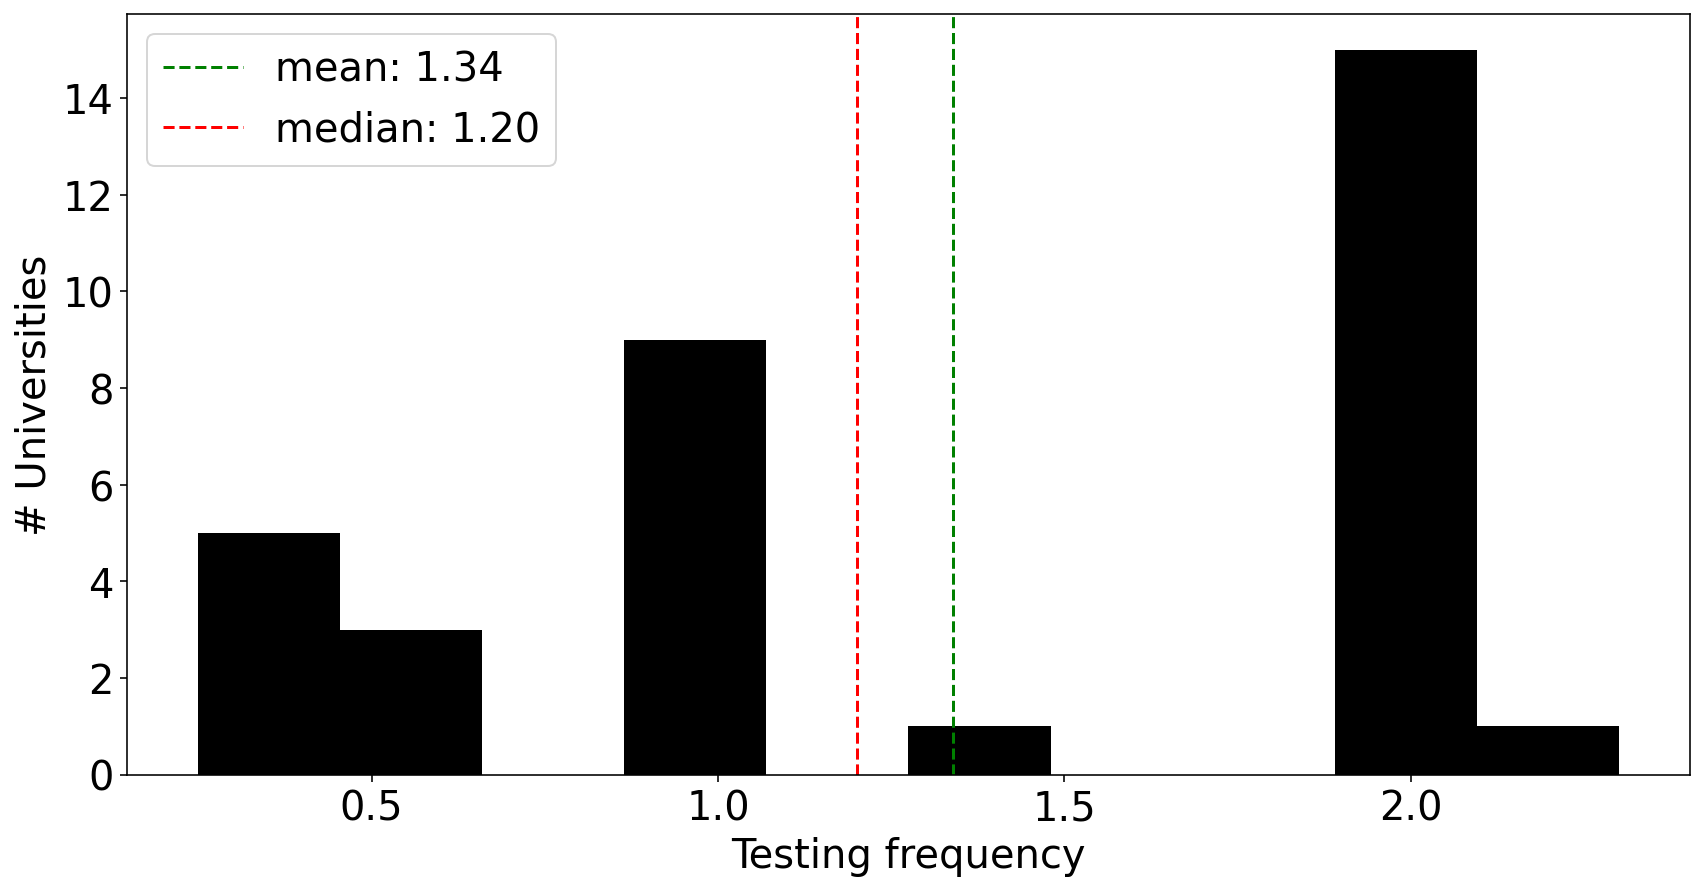

In [88]:
fig, ax = plt.subplots(figsize=(14,7))
x = df[df.test_freq.notna()].query("test_freq>0").test_freq.values

mean = x.mean()
median = np.median(x)
ax.hist(x, color="k")
ax.axvline(mean, label=f"mean: {mean:,.2f}", color="green", linestyle="--")
ax.axvline(median, label=f"median: {median:,.2f}", color="red", linestyle="--")
kwd = {
    "xlabel": "Testing frequency",
    "ylabel": "# Universities"
}
ax.set(**kwd)
ax.legend()

fig.show()

# Top 5 states by number of universities

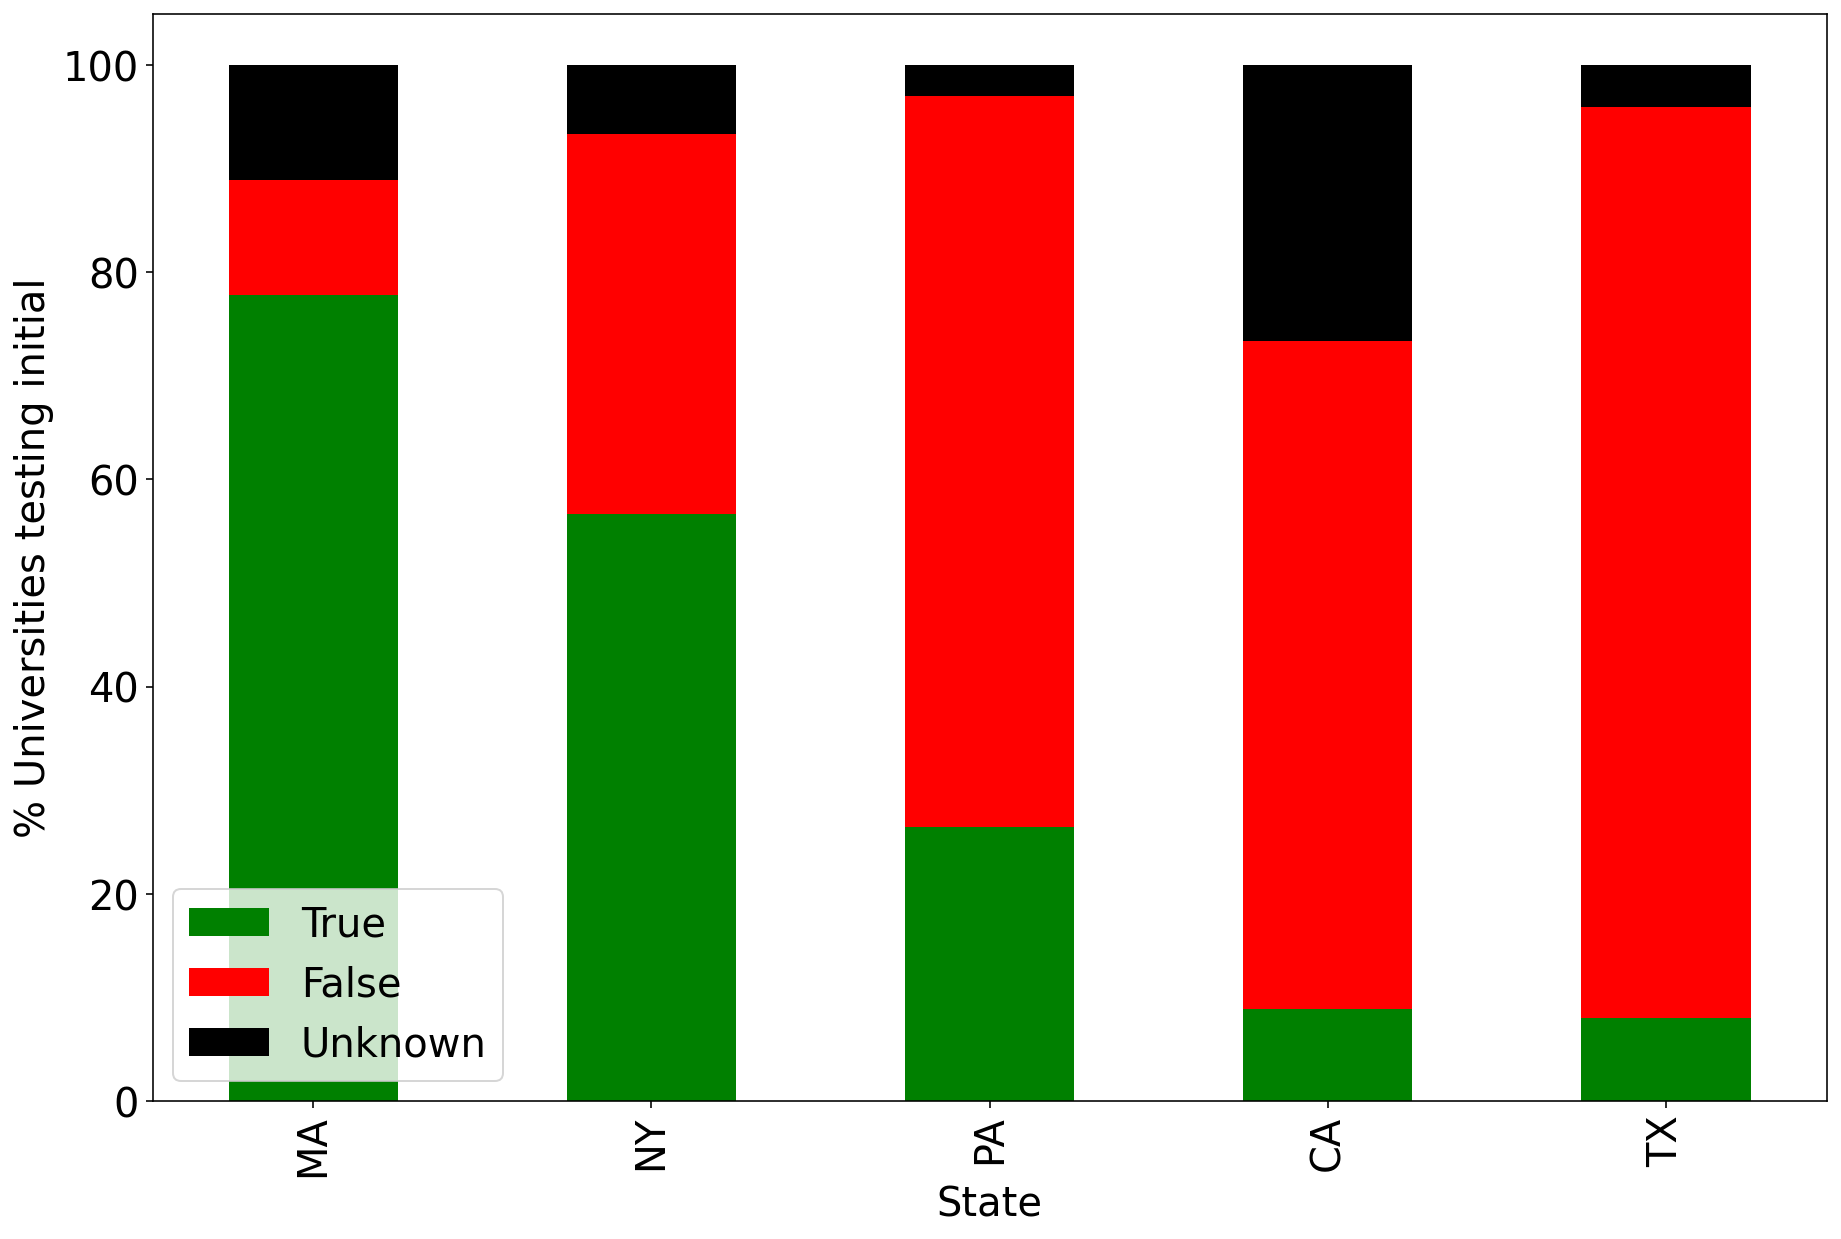

In [90]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values
width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing initial"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

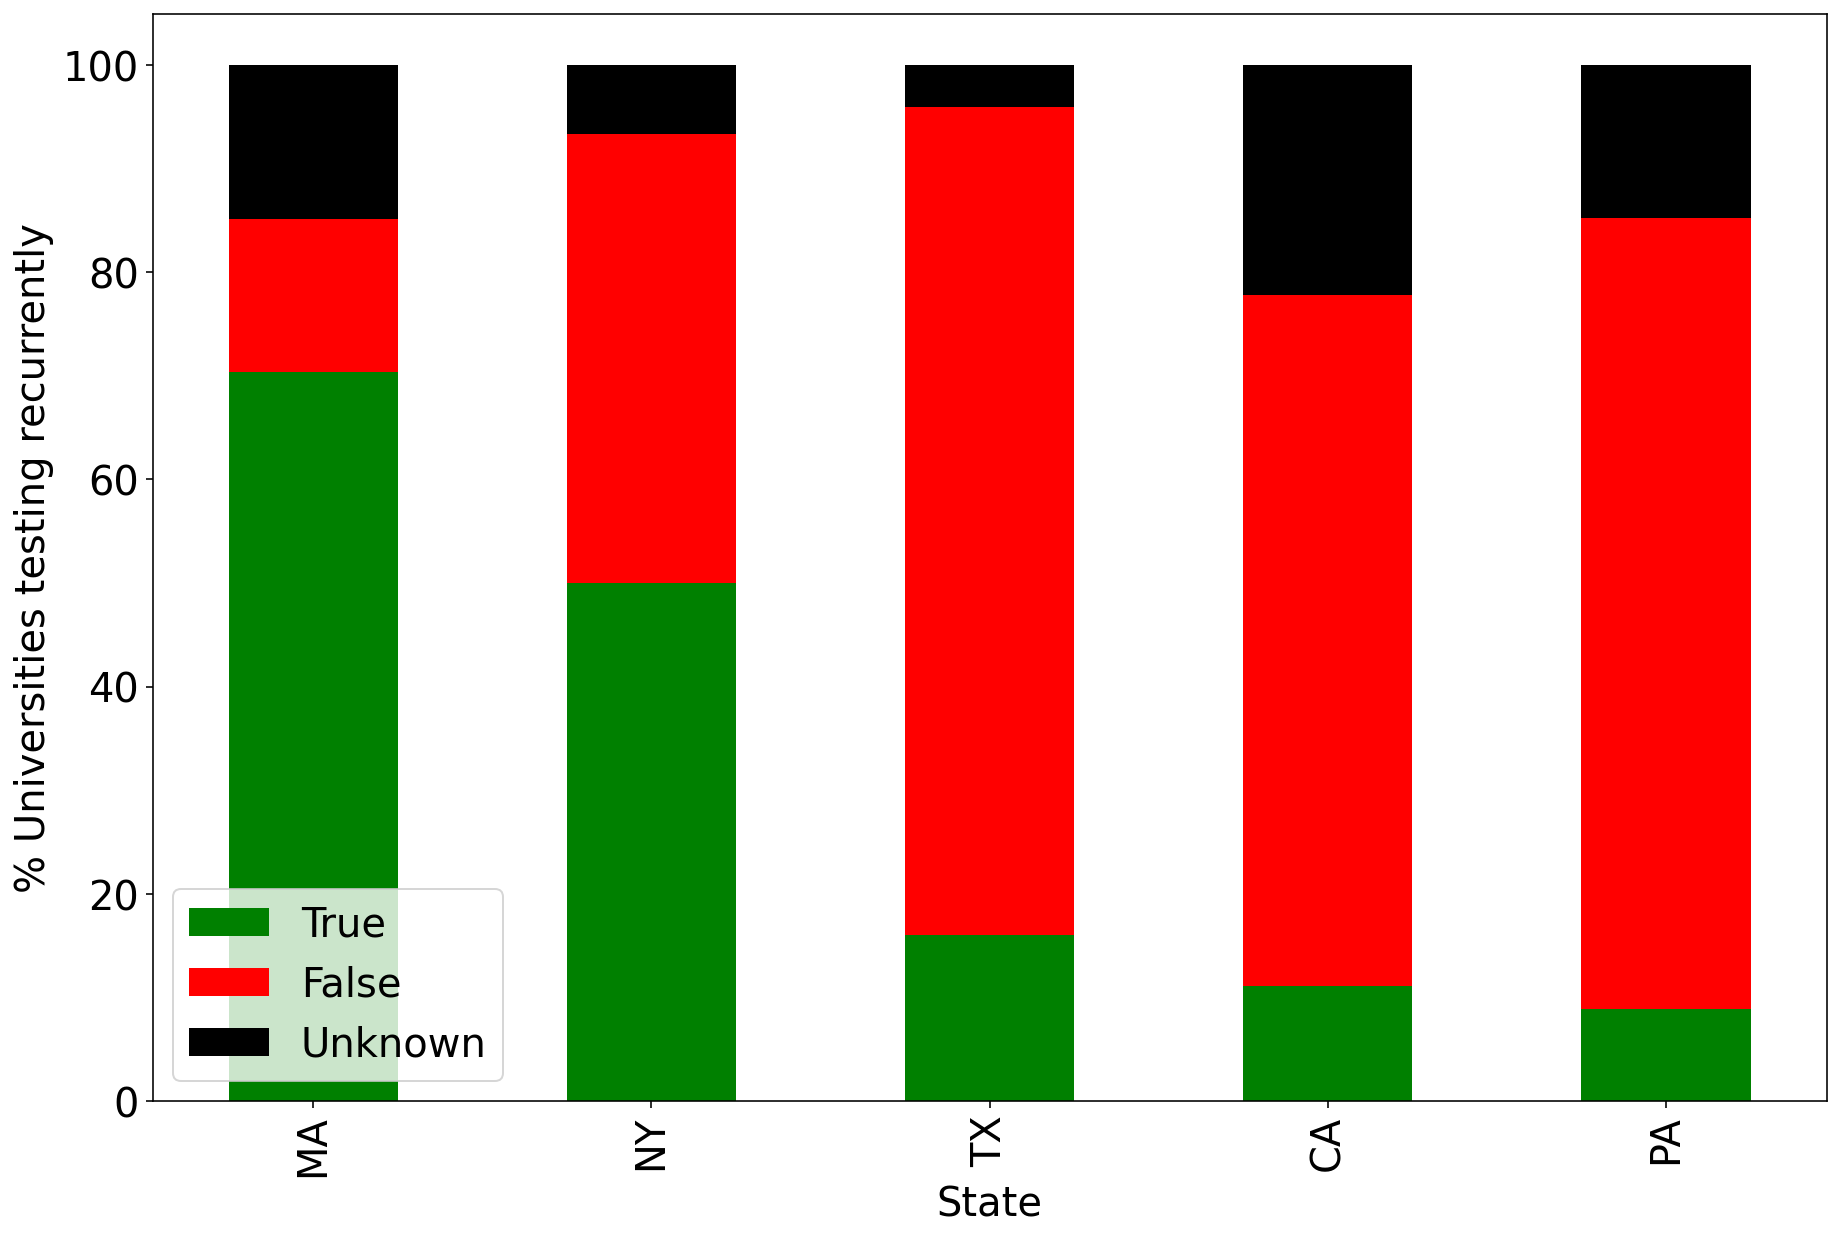

In [91]:
v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values

width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing recurrently"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

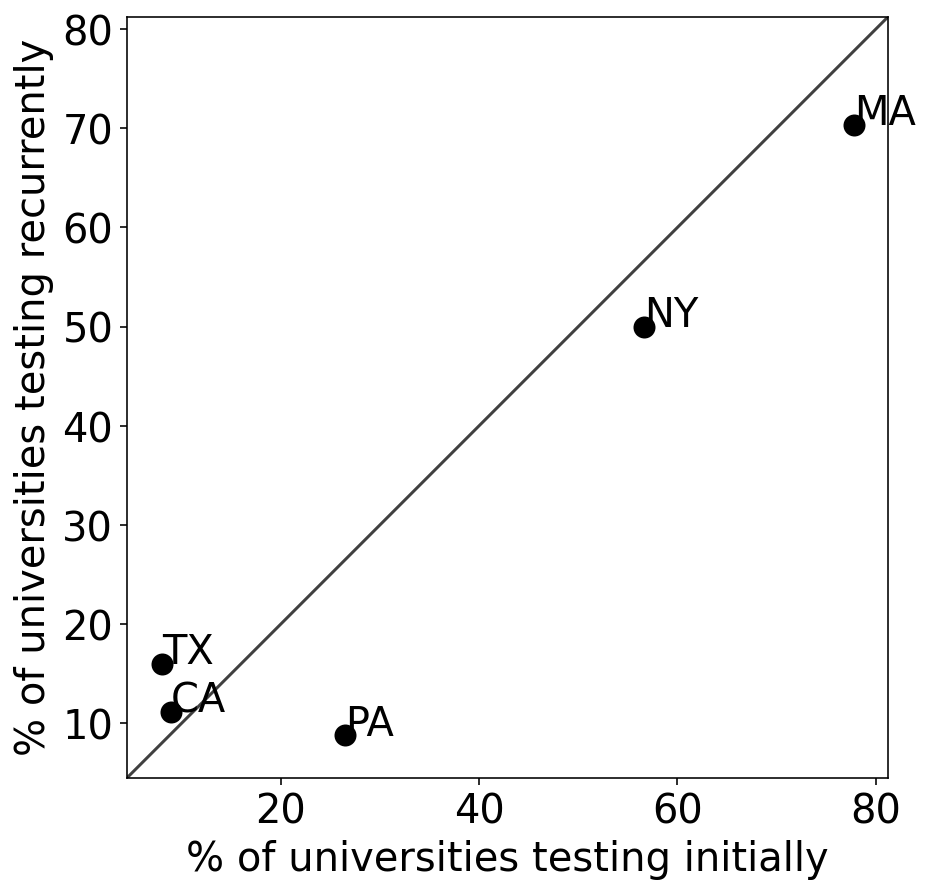

In [92]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
recurrent = v/v.values.sum(axis=1)[:,None]*100

initial = initial.loc[top_states]
recurrent = recurrent.loc[top_states]

fig, ax = plt.subplots(figsize=(7,7))

x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y, s=100, color="k")
yex(ax)
for (xx, yy, txt) in zip(x, y, top_states):
  ax.annotate(txt, (xx, yy))

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)

fig.show()

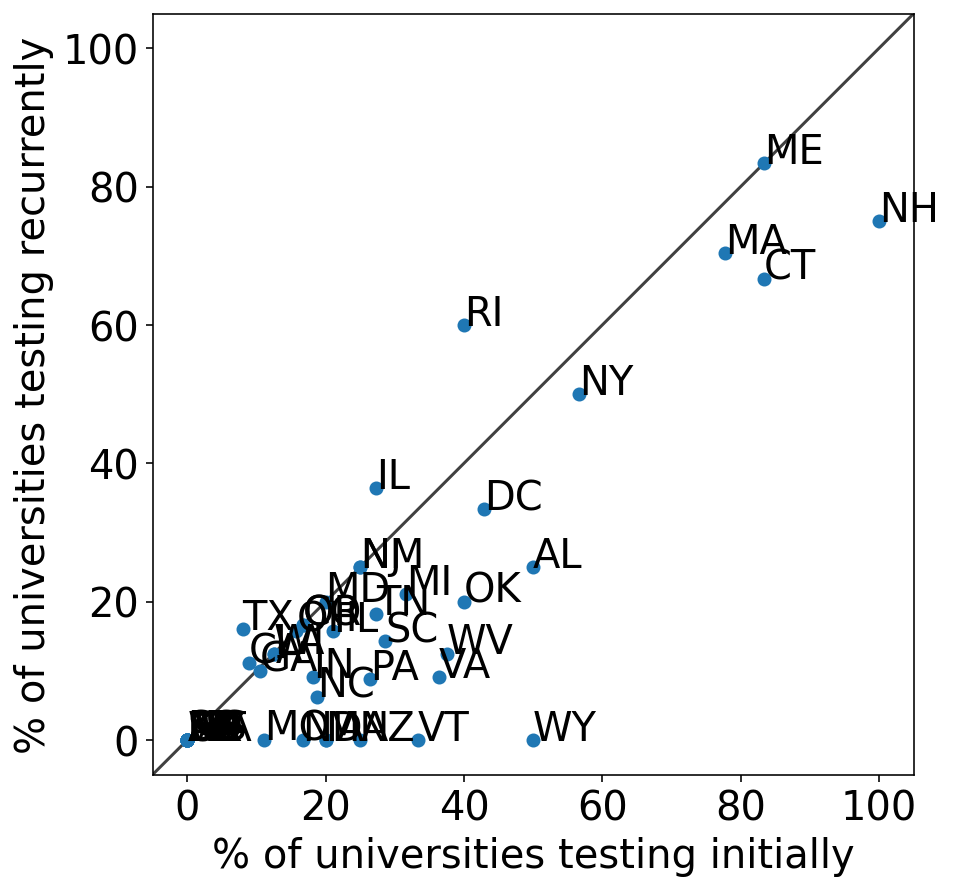

In [93]:
# all states
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0)
recurrent = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(7,7))


x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y)
yex(ax)

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)
for (xx, yy, txt) in zip(x, y, initial.index.values):
  ax.annotate(txt, (xx, yy))
fig.show()

# Positivity rate per state

In [182]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/08-02-2020.csv -O daily.csv

--2020-08-03 05:30:43--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/08-02-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9714 (9.5K) [text/plain]
Saving to: ‘daily.csv’

daily.csv           100%[===================>]   9.49K  --.-KB/s    in 0s      

2020-08-03 05:30:43 (76.0 MB/s) - ‘daily.csv’ saved [9714/9714]



In [183]:
daily = pd.read_csv("daily.csv")

In [185]:
s2a = {
"Alabama"	: "AL",
"Alaska"	: "AK",
"Arizona"	: "AZ",
"Arkansas"	: "AR",
"California"	: "CA",
"Colorado"	: "CO",
"Connecticut"	: "CT",
"Delaware"	: "DE",
"Florida"	: "FL",
"Georgia"	: "GA",
"Hawaii"	: "HI",
"Idaho"	: "ID",
"Illinois"	: "IL",
"Indiana"	: "IN",
"Iowa"	: "IA",
"Kansas"	: "KS",
"Kentucky"	: "KY",
"Louisiana"	: "LA",
"Maine"	: "ME",
"Maryland"	: "MD",
"Massachusetts"	: "MA",
"Michigan"	: "MI",
"Minnesota"	: "MN",
"Mississippi"	: "MS",
"Missouri"	: "MO",
"Montana"	: "MT",
"Nebraska"	: "NE",
"Nevada"	: "NV",
"New Hampshire"	: "NH",
"New Jersey"	: "NJ",
"New Mexico"	: "NM",
"New York"	: "NY",
"North Carolina"	: "NC",
"North Dakota"	: "ND",
"Ohio"	: "OH",
"Oklahoma"	: "OK",
"Oregon"	: "OR",
"Pennsylvania"	: "PA",
"Rhode Island"	: "RI",
"South Carolina"	: "SC",
"South Dakota"	: "SD",
"Tennessee"	: "TN",
"Texas"	: "TX",
"Utah"	: "UT",
"Vermont"	: "VT",
"Virginia"	: "VA",
"Washington"	: "WA",
"West Virginia"	: "WV",
"Wisconsin"	: "WI",
"Wyoming"	: "WY"
}

In [188]:
daily["state"] = daily["Province_State"].apply(lambda x: s2a.get(x,x))
daily.index = daily.state.values

In [191]:
daily.columns

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3',
       'Testing_Rate', 'Hospitalization_Rate', 'state'],
      dtype='object')

In [192]:
daily.loc[top_states]["Incident_Rate"].values

CA    1296.244456
NY    2139.957821
PA     921.989544
TX    1545.547107
MA    1718.649959
Name: Incident_Rate, dtype: float64

In [129]:
rate = [
        6.5,
        1.0,
        5.8,
        12.4,
        3.0,
]

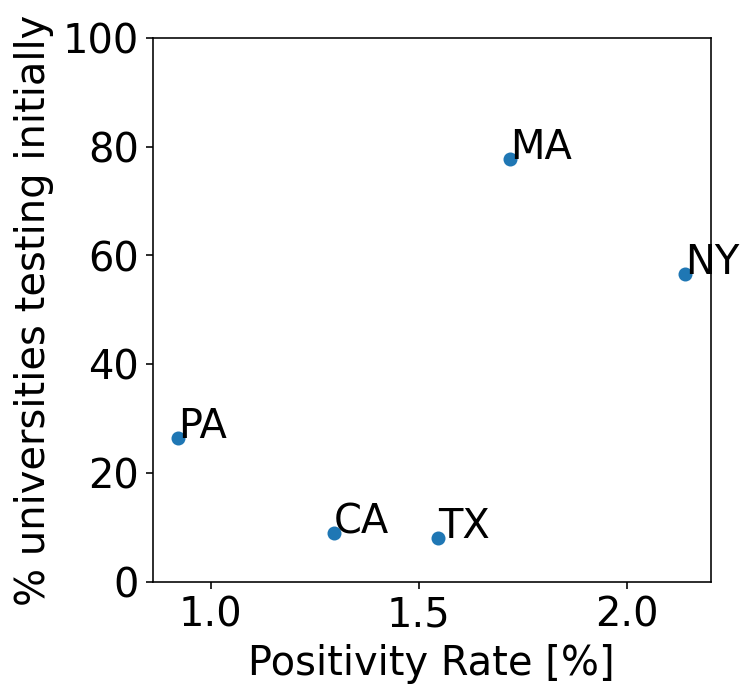

In [199]:
fig, ax = plt.subplots(figsize=(5,5))
#x = r.loc[top_states].values*100#rate
x = daily.loc[top_states]["Incident_Rate"].values/1000
y = initial.loc[top_states].TRUE.values
ax.scatter(x, y)

for (xx, yy, txt) in zip(x, y, top_states):
  ax.annotate(txt, (xx, yy))

kwd = {
    "xlabel": "Positivity Rate [%]",
    "ylabel": "% universities testing initially",
    "ylim": (0, 100),
    #"xlim": (0, 15)
}

ax.set(**kwd)
fig.show()

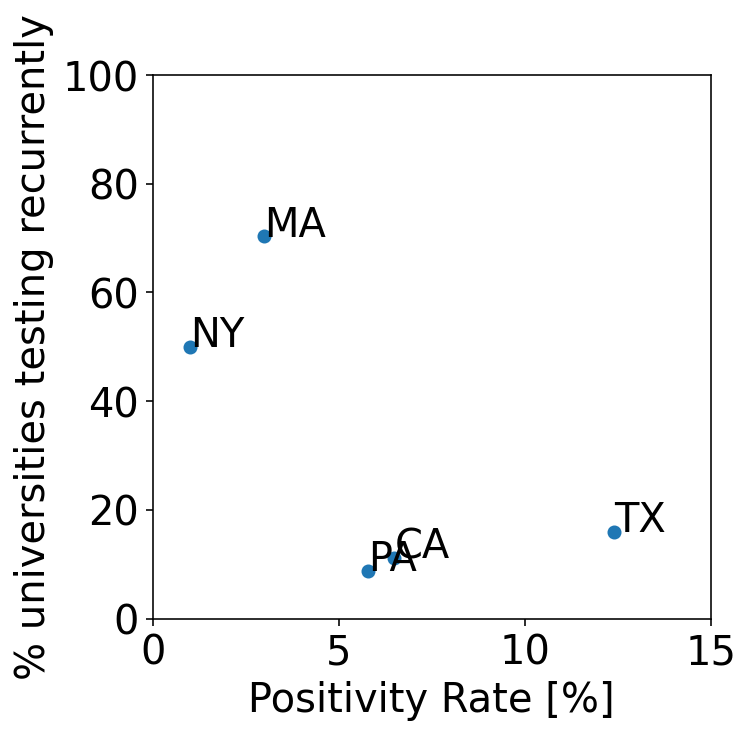

In [135]:
fig, ax = plt.subplots(figsize=(5,5))
x = rate
y = recurrent.loc[top_states].TRUE.values
ax.scatter(x, y)

for (xx, yy, txt) in zip(x, y, top_states):
  ax.annotate(txt, (xx, yy))

kwd = {
    "xlabel": "Positivity Rate [%]",
    "ylabel": "% universities testing recurrently",
    "ylim": (0, 100),
    "xlim": (0, 15)
}

ax.set(**kwd)
fig.show()

# US News top universities

In [18]:
usnr = pd.read_excel("http://andyreiter.com/wp-content/uploads/2019/09/US-News-Rankings-Universities-Through-2020.xlsx", header=1)

In [19]:
np.setdiff1d(usnr["University Name"], df.institution.values)

array(['College of William and Mary', 'Georgia Institute of Technology',
       'Pennsylvania State University-University Park',
       'Rutgers University-New Brunswick',
       'Texas A&M University-College Station',
       'University of California-Berkeley',
       'University of California-Davis',
       'University of California-Irvine',
       'University of California-Los Angeles',
       'University of California-San Diego',
       'University of California-Santa Barbara', 'University of Georgia',
       'University of Illinois-Urbana-Champaign',
       'University of Michigan-Ann Arbor',
       'University of North Carolina-Chapel Hill',
       'University of Texas-Austin', 'University of Wisconsin-Madison'],
      dtype=object)

In [20]:
top_map = {
  'College of William and Mary':"College of William & Mary", 
  'Georgia Institute of Technology': "University System of Georgia — Georgia Institute of Technology",
  'Pennsylvania State University-University Park': "Pennsylvania State University",
  'Rutgers University-New Brunswick': "Rutgers University",
  'Texas A&M University-College Station': "Texas A&M University system — College Station",
  'University of California-Berkeley': "University of California at Berkeley",
  'University of California-Davis':"University of California at Davis",
  'University of California-Irvine':"University of California at Irvine",
  'University of California-Los Angeles': "University of California at Los Angeles",
  'University of California-San Diego': "University of California at San Diego",
  'University of California-Santa Barbara': "University of California at Santa Barbara", 
  'University of Georgia': "University System of Georgia — University of Georgia",
  'University of Illinois-Urbana-Champaign': "University of Illinois at Urbana-Champaign",
  'University of Michigan-Ann Arbor': "University of Michigan at Ann Arbor",
  'University of North Carolina-Chapel Hill': "University of North Carolina at Chapel Hill",
  'University of Texas-Austin':"University of Texas at Austin", 
  'University of Wisconsin-Madison': "University of Wisconsin at Madison"
}

In [21]:
usnr["University Name"] = usnr["University Name"].apply(lambda x: top_map.get(x, x))

In [66]:
usnr = usnr[usnr[2020].notna()].sort_values(2020).head(50)

In [67]:
top_uni = df[df.institution.isin(usnr["University Name"].values)]

In [69]:
top_uni.shape

(50, 14)

In [70]:
top_uni.groupby(["rtc_model", "testing"]).size().unstack(fill_value=0)

testing,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,0,8,0
Planning for online,0,5,0
Proposing a hybrid model,1,32,2


In [73]:
top_uni.query("testing=='FALSE'")

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,comments
Case Western Reserve University,Case Western Reserve University,Private,OH,https://case.edu/studentlife/healthcounseling/...,Proposing a hybrid model,7/28/2020,FALSE,No voluntary testing,FALSE,FALSE,0.0,NaN,NaN,NaN


In [71]:
top_uni.groupby(["rtc_model", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,2,5,1
Planning for online,4,1,0
Proposing a hybrid model,7,25,3


In [78]:
top_uni.groupby(["school_type", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
school_type,,,
Private,4,28,3
Public,9,5,1


In [96]:
top_uni.groupby(["school_type", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
school_type,,,
Private,8,22,5
Public,10,4,1


In [97]:
df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
school_type,,,
Private,124,67,27
Public,165,29,22


In [98]:
df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
school_type,,,
Private,132,51,35
Public,164,20,29


In [75]:
top_uni.query("test_initial=='FALSE'").institution.values

array(['Carnegie Mellon University', 'Case Western Reserve University',
       'Pepperdine University', 'University of California at Davis',
       'University of California at Irvine',
       'University of California at Los Angeles',
       'University of California at Santa Barbara',
       'University of Michigan at Ann Arbor',
       'University of North Carolina at Chapel Hill',
       'University of Southern California',
       'University of Texas at Austin',
       'University of Wisconsin at Madison',
       'University System of Georgia — Georgia Institute of Technology'],
      dtype=object)

In [77]:
top_uni[top_uni.institution.str.contains("Berkeley")]

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,comments
University of California at Berkeley,University of California at Berkeley,Public,CA,https://sa.berkeley.edu/covid19/Fall2020,Planning for in-person,7/25/2020,TRUE,Symptomatic,Unknown,Unknown,NaN,"University Health Services, Innovative Genomic...",NaN,Surveillance screening planned but constrained...


In [72]:
top_uni.groupby(["rtc_model", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,0,1
Considering a range of scenarios,0,1,0
Planning for in-person,4,3,1
Planning for online,3,2,0
Proposing a hybrid model,11,20,4


In [26]:
v = top_uni.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,14,2,0
TRUE,6,29,4
Unknown,1,1,4


# Scraping college case data from the NYT

In [27]:
from bs4 import BeautifulSoup 

In [28]:
with open("/content/COVID-19-testing-database/data/nyt.txt", "r", encoding='utf-8') as f:
    text = f.read()

In [29]:
s = BeautifulSoup(text)

In [30]:
schoolname = []
schoolcases = []
schoolloc = []

sn = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolname"})
sc = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolcases"})
sl = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolloc"})
for (n, c, l) in zip(sn, sc, sl):
  name = n.text.strip()
  casenum = int(c.text.strip())
  loc = l.text.strip()
  if "*" in name:
    name = name.replace("*", "")
  if "," in name:
    name = name.replace(",", " at")
    print(name)
  schoolname.append(name)
  schoolcases.append(casenum)
  schoolloc.append(loc)

University of California at Berkeley
University of California at Los Angeles
University of California at Irvine
University of California at Davis
California State University at Long Beach
University of Nevada at Reno
University of Nevada at Las Vegas
University of Maryland at College Park
California Polytechnic State University at San Luis Obispo
University of California at Riverside
California State University at Northridge
University of Maryland at Baltimore County
University of California at Santa Cruz
California State University at East Bay
University of South Florida at St. Petersburg
University of California at Santa Barbara
California State University at Dominguez Hills
California State University at San Marcos
California State University at San Bernardino
California State Polytechnic University at Pomona
California State University at Chico
California State University at Channel Islands
University of Tennessee at Knoxville


In [47]:
cases = pd.DataFrame({"institution": schoolname, "cases":schoolcases, "location":schoolloc})
cases.index = cases["institution"].values

In [32]:
np.intersect1d(top_uni.institution.values, cases.institution.values).shape

(27,)

In [33]:
np.setdiff1d(top_uni.institution.values, cases.institution.values)

array(['Boston University', 'Brandeis University', 'Brown University',
       'Case Western Reserve University', 'College of William & Mary',
       'Cornell University', 'Duke University', 'Emory University',
       'George Washington University', 'Harvard University',
       'Johns Hopkins University', 'Lehigh University',
       'Massachusetts Institute of Technology', 'New York University',
       'Northeastern University', 'Pennsylvania State University',
       'Rensselaer Polytechnic Institute', 'Rutgers University',
       'Syracuse University',
       'Texas A&M University system — College Station',
       'Tufts University', 'Tulane University',
       'University System of Georgia — Georgia Institute of Technology',
       'University System of Georgia — University of Georgia',
       'University of California at San Diego',
       'University of Illinois at Urbana-Champaign',
       'University of Miami', 'University of Michigan at Ann Arbor',
       'University of Wisconsi

In [94]:
cases

,institution,cases,location
University of Texas at Austin,University of Texas at Austin,449,"Austin, Texas"
University of Central Florida,University of Central Florida,438,"Orlando, Fla."
University of Georgia,University of Georgia,390,"Athens, Ga."
Texas A&M University,Texas A&M University,302,"College Station, Texas"
University of Washington,University of Washington,249,Seattle
...,...,...,...
William Paterson University,William Paterson University,1,"Wayne, N.J."
Carnegie Mellon University,Carnegie Mellon University,1,Pittsburgh
Barnard College,Barnard College,1,New York City
Winthrop University,Winthrop University,1,"Rock Hill, S.C."


In [34]:
cases[cases.institution.str.contains("Mass")]

,institution,cases,location
144,University of Massachusetts Amherst,6,"Amherst, Mass."
171,University of Massachusetts Medical School,4,"Worcester, Mass."


In [49]:
top_uni["cases"] = top_uni.institution.map(cases["cases"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
top_uni[top_uni["cases"].notna()].groupby("test_initial")["cases"].sum()

test_initial
FALSE      764.0
TRUE       762.0
Unknown    388.0
Name: cases, dtype: float64

In [55]:
top_uni[top_uni["cases"].notna()].groupby("test_recurring")["cases"].sum()

test_recurring
FALSE      970.0
TRUE       401.0
Unknown    543.0
Name: cases, dtype: float64